In [1]:
import numpy as np
import matplotlib.pyplot as plt
import visualization
import os
from gta_math import points_to_homo, ndc_to_view, construct_proj_matrix, view_to_world, construct_view_matrix, \
    is_entity_in_image, calculate_2d_bbox, get_model_3dbbox, model_coords_to_pixel
from visualization import load_depth, load_stencil, save_pointcloud_csv, bbox_from_string, draw3dbboxes, \
    draw_one_entity_3dbbox, draw3dbboxes_pillow, draw_one_entity_3dbbox_pillow, calculate_one_entity_bbox, \
    are_buffers_same_as_previous, draw_one_entity_3dbbox_matplotlib
import progressbar
from joblib import Parallel, delayed
from configparser import ConfigParser
from PIL import Image
import pickle
import json
from datetime import timedelta, datetime, date
from matplotlib.dates import DateFormatter, DateFormatter, HourLocator
import matplotlib as mpl

In [2]:
ini_file = "gta-postprocessing.ini"
visualization.multi_page = False
visualization.ini_file = ini_file

conn = visualization.get_connection()
cur = conn.cursor()

CONFIG = ConfigParser()
CONFIG.read(ini_file)
#directory = r'D:\generic-dataset'
directory = r'D:\output-datasets\onroad-1'


In [3]:
# suspicious data, inspect them later
'2018-03-30--05-22-21--832'
'2018-03-30--09-41-06--808'
'2018-03-30--04-24-44--718'
'2018-03-07--15-22-37--478'
'2018-03-07--16-19-25--084'
'2018-03-07--17-32-15--567'
'2018-03-07--16-18-02--972'

'2018-08-13--20-41-07--192'
'2018-08-13--20-41-08--763'
'2018-08-13--20-41-01--110'
'2018-08-13--21-05-07--241'

'2018-08-13--21-05-07--241'

In [4]:
#base_name = '2018-03-30--04-35-59--854'
base_name = '2018-08-13--21-05-07--241'

rgb_file = os.path.join(directory, '{}.jpg'.format(base_name))
depth_file = os.path.join(directory, '{}-depth.png'.format(base_name))
stencil_file = os.path.join(directory, '{}-stencil.png'.format(base_name))
json_file = os.path.join(directory, '{}.json'.format(base_name))
rgb = np.array(Image.open(rgb_file))
depth = np.array(Image.open(depth_file))
depth = depth / np.iinfo(np.uint16).max  # normalizing into NDC
stencil = np.array(Image.open(stencil_file))
with open(json_file, mode='r') as f:
    data = json.load(f)


In [5]:
entities = data['entities']
view_matrix = np.array(data['view_matrix'])
proj_matrix = np.array(data['proj_matrix'])
if 'width' in data:
    width = data['width']
else:
    width = 1914
    data['width'] = width
if 'height' in data:
    height = data['height']
else:
    height = 1052
    data['height'] = height
    
visible_cars = [e for e in entities if
                e['type'] == 'car' and e['class'] != 'Trains' and is_entity_in_image(depth, stencil, e, view_matrix,
                                                                                     proj_matrix, width, height)]
#visible_cars[4]

In [6]:
for visible_car in visible_cars:
        visible_car['bbox_calc'] = calculate_2d_bbox(visible_car, view_matrix, proj_matrix, width, height)
        bbox = np.array(visible_car['bbox_calc'])
        bbox[:, 0] *= width
        bbox[:, 1] *= height
        visible_car['bbox_calc_img'] = bbox

visible_cars[1]

{'bbox': [[0.594780623912811, 0.688946604728699],
  [0.331076890230179, 0.295622915029526]],
 'bbox_calc': [[0.5926069264722853, 0.6889506672035628],
  [0.3349474023624317, 0.2956359071752948]],
 'bbox_calc_img': array([[ 1134.24965727,   724.7761019 ],
        [  641.08932812,   311.00897435]]),
 'class': 'SUVs',
 'handle': 252171,
 'model_sizes': [-1.00014805793762,
  1.00014805793762,
  -2.31411194801331,
  2.40208530426025,
  -0.347098022699356,
  1.31979048252106],
 'pos': [-457.355194091797, -1384.24694824219, 29.495138168335],
 'rot': [-4.57577800750732, -1.23613107204437, 173.81120300293],
 'type': 'car'}

2D bbox: [[ 1134.24965727   724.7761019 ]
 [  641.08932812   311.00897435]]


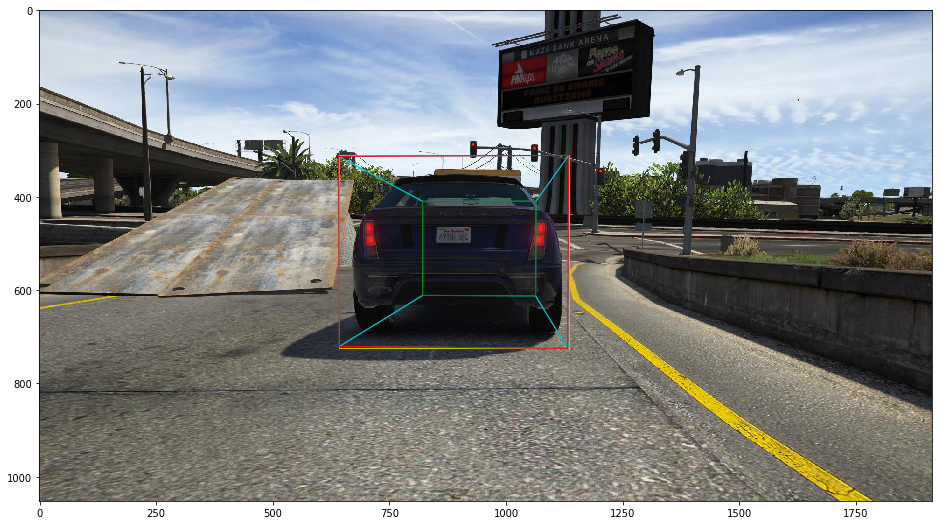

In [7]:
fig = plt.figure(figsize=(16, 12))
#draw3dbboxes(rgb, depth, data, fig)
plt.imshow(rgb)
#visible_cars = [e for e in entities if
#                e['type'] == 'car' and e['class'] != 'Trains' and is_entity_in_image(depth, stencil, e, view_matrix,
#                                                                                     proj_matrix, width, height)]
draw_one_entity_3dbbox(visible_cars[1], view_matrix, proj_matrix, width, height, fig.gca())
#for visible_car in visible_cars:
#    draw_one_entity_3dbbox(visible_car, view_matrix, proj_matrix, width, height, fig.gca())
plt.show()

2D bbox: [[ 1134.24965727   724.7761019 ]
 [  641.08932812   311.00897435]]


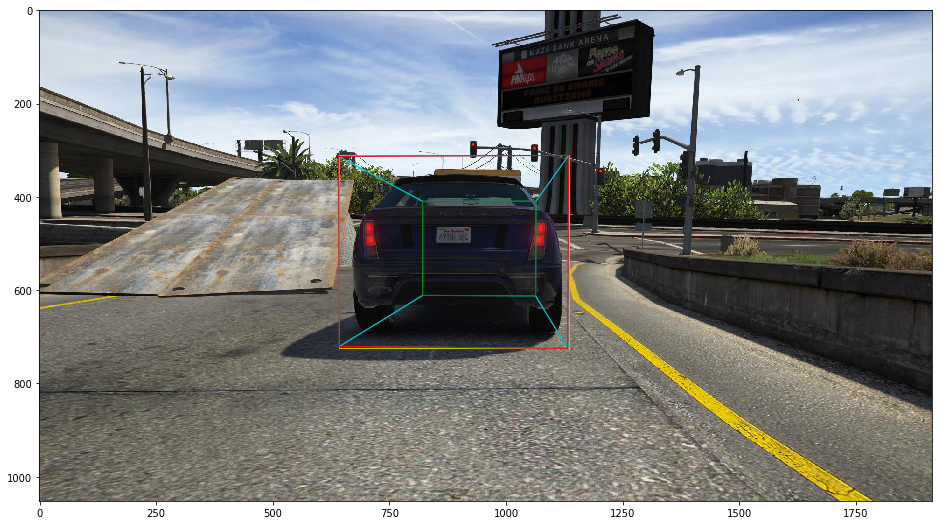

In [8]:
row = visible_cars[1]
row['bbox_calc'] = calculate_2d_bbox(row, view_matrix, proj_matrix, width, height)
pos = np.array(row['pos'])

bbox = np.array(row['bbox_calc'])
bbox[:, 0] *= width
bbox[:, 1] *= height

    # 3D bounding box
rot = np.array(row['rot'])
model_sizes = np.array(row['model_sizes'])
points_3dbbox = get_model_3dbbox(model_sizes)

# projecting cuboid to 2d
bbox_2d = model_coords_to_pixel(pos, rot, points_3dbbox, view_matrix, proj_matrix, width, height).T

fig = plt.figure(figsize=(16, 12))
plt.imshow(rgb)
draw_one_entity_3dbbox_matplotlib(bbox, bbox_2d, plt.gca())
plt.show()


In [46]:
data['snapshot_id']

488403

In [9]:
rgb_file = os.path.join(directory, '2018-03-30--05-22-21--832.jpg')
depth_file = os.path.join(directory, '2018-03-30--05-22-21--832-depth.png')
json_file = os.path.join(directory, '2018-03-30--05-22-21--832.json')
rgb = np.array(Image.open(rgb_file))
depth = np.array(Image.open(depth_file))
depth = depth / np.iinfo(np.uint16).max  # normalizing into NDC
with open(json_file, mode='r') as f:
    data = json.load(f)


camera pos:  [2477.35888671875, 5103.86328125, 46.0536575317383]
2D bbox: [[ 1116.54716131   601.47909939]
 [  705.23786472   215.50972247]]


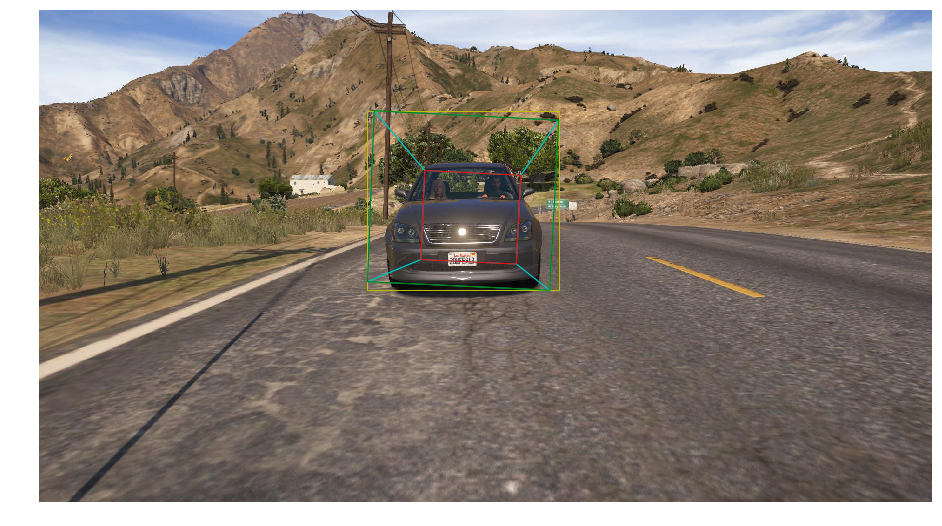

In [10]:
fig = plt.figure(figsize=(16, 12))
draw3dbboxes(rgb, depth, data, fig)
plt.show()

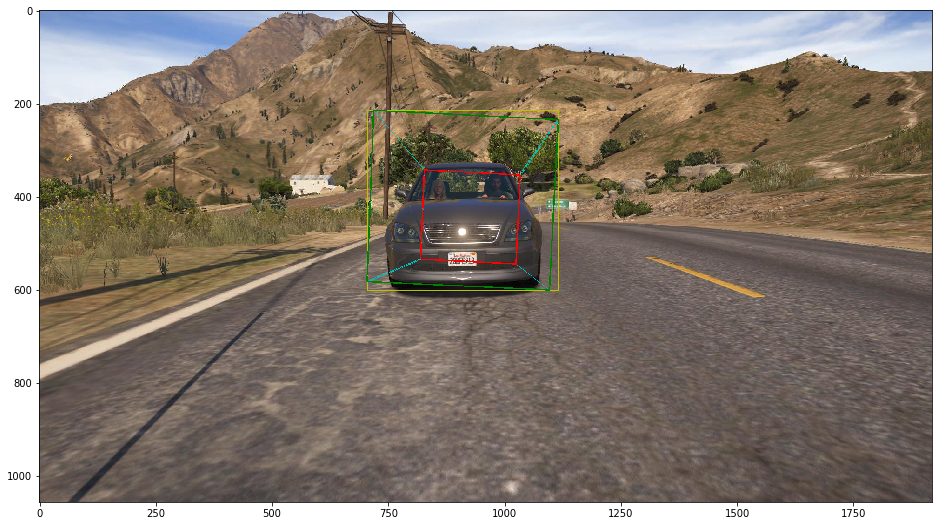

In [11]:
im = draw3dbboxes_pillow(rgb, depth, data)
fig = plt.figure(figsize=(16, 12))
plt.imshow(np.array(im))
plt.show()


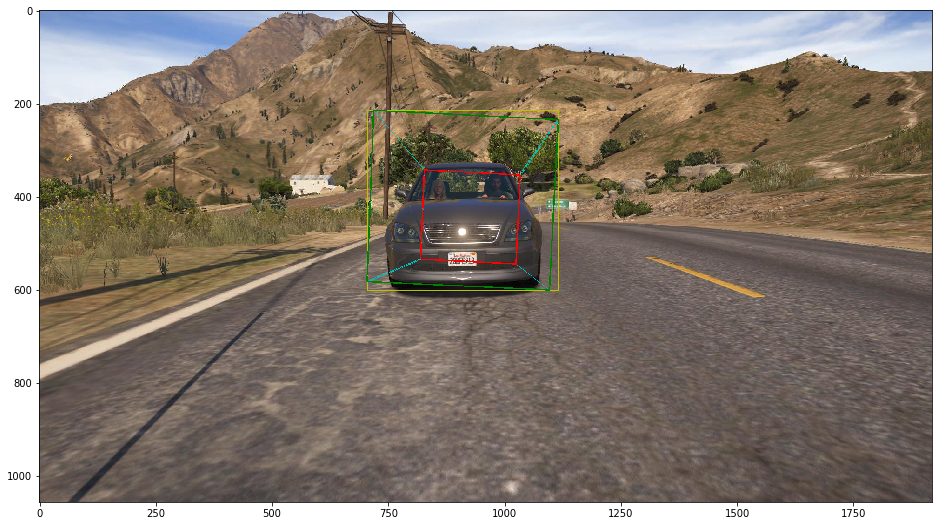

In [63]:
from PIL import Image, ImageFile, ImageDraw
from matplotlib import cm, patches, colors

entities = data['entities']
view_matrix = np.array(data['view_matrix'])
proj_matrix = np.array(data['proj_matrix'])
width = data['width']
height = data['height']
# visible_cars = [e for e in entities if e['bbox'][0] != [np.inf, np.inf] and e['type'] == 'car']
visible_cars = [e for e in entities if
                e['type'] == 'car' and e['class'] != 'Trains' and is_entity_in_image(depth, stencil, e, view_matrix,
                                                                                     proj_matrix, width, height)]

im = Image.fromarray(rgb)

bbox, bbox_2d = calculate_one_entity_bbox(visible_cars[0], view_matrix, proj_matrix, width, height)

draw = ImageDraw.Draw(im)
draw.rectangle(bbox[0, :].tolist() + bbox[1, :].tolist(), outline=colors.to_hex('y'))
draw.rectangle((bbox[0, :] + 1).tolist() + (bbox[1, :] + 1).tolist(), outline=colors.to_hex('y'))   # increase width

draw.polygon((bbox_2d[(0, 1, 3, 2), :]+0).flatten().tolist(), outline=colors.to_hex('c'))
draw.polygon((bbox_2d[(0, 1, 3, 2), :]+1).flatten().tolist(), outline=colors.to_hex('c'))
draw.polygon((bbox_2d[(0, 1, 3, 2), :]-1).flatten().tolist(), outline=colors.to_hex('c'))
draw.polygon((bbox_2d[(4, 5, 7, 6), :]+0).flatten().tolist(), outline=colors.to_hex('c'))
draw.polygon((bbox_2d[(4, 5, 7, 6), :]+1).flatten().tolist(), outline=colors.to_hex('c'))
draw.polygon((bbox_2d[(4, 5, 7, 6), :]-1).flatten().tolist(), outline=colors.to_hex('c'))
draw.polygon((bbox_2d[(0, 2, 6, 4), :]+0).flatten().tolist(), outline=colors.to_hex('c'))
draw.polygon((bbox_2d[(0, 2, 6, 4), :]+1).flatten().tolist(), outline=colors.to_hex('c'))
draw.polygon((bbox_2d[(0, 2, 6, 4), :]-1).flatten().tolist(), outline=colors.to_hex('c'))
draw.polygon((bbox_2d[(1, 3, 7, 5), :]+0).flatten().tolist(), outline=colors.to_hex('c'))
draw.polygon((bbox_2d[(1, 3, 7, 5), :]+1).flatten().tolist(), outline=colors.to_hex('c'))
draw.polygon((bbox_2d[(1, 3, 7, 5), :]-1).flatten().tolist(), outline=colors.to_hex('c'))
draw.polygon((bbox_2d[(0, 1, 5, 4), :]+0).flatten().tolist(), outline=colors.to_hex('r'))
draw.polygon((bbox_2d[(0, 1, 5, 4), :]+1).flatten().tolist(), outline=colors.to_hex('r'))
draw.polygon((bbox_2d[(0, 1, 5, 4), :]-1).flatten().tolist(), outline=colors.to_hex('r'))
draw.polygon((bbox_2d[(2, 3, 7, 6), :]+0).flatten().tolist(), outline=colors.to_hex('g'))
draw.polygon((bbox_2d[(2, 3, 7, 6), :]+1).flatten().tolist(), outline=colors.to_hex('g'))
draw.polygon((bbox_2d[(2, 3, 7, 6), :]-1).flatten().tolist(), outline=colors.to_hex('g'))

fig = plt.figure(figsize=(16, 12))
plt.imshow(np.array(im))
plt.show()


In [55]:
bbox_2d[(0, 1, 5, 4), :].flatten().tolist()

[1025.2921214348407,
 545.2452531257043,
 1034.955342124855,
 354.3228797192962,
 828.3984390031305,
 343.99840270955485,
 820.0749369802704,
 535.4792058605932]

there are 4 results
camera relative rot:
camera pos:  [329.492126464844, -1343.05322265625, 32.3984642028809]
2D bbox: [[ 1915.00052274   527.71470368]
 [ 1833.71964594   462.14718249]]
2D bbox: [[   2.54785829  625.62051418]
 [   0.          584.56427542]]


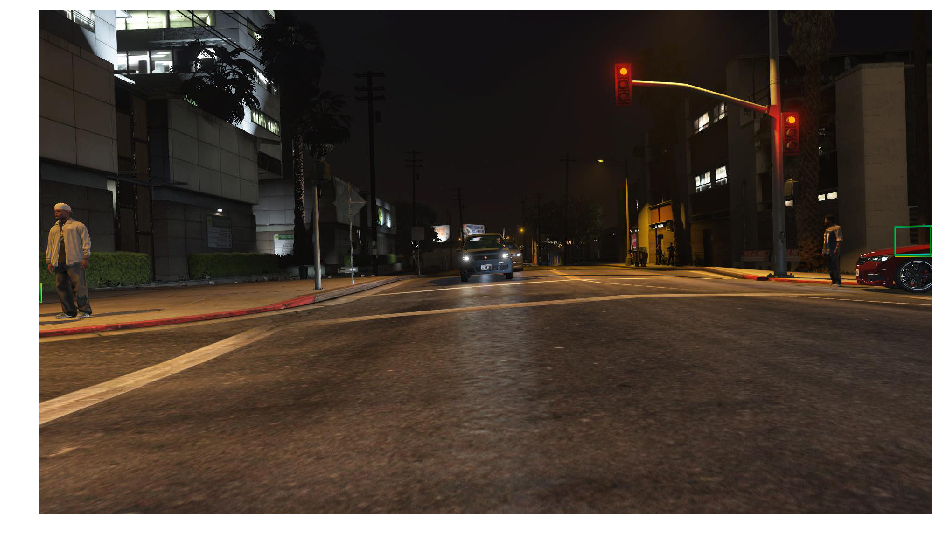

camera relative rot:
camera pos:  [340.74658203125, -1341.95837402344, 32.0259742736816]


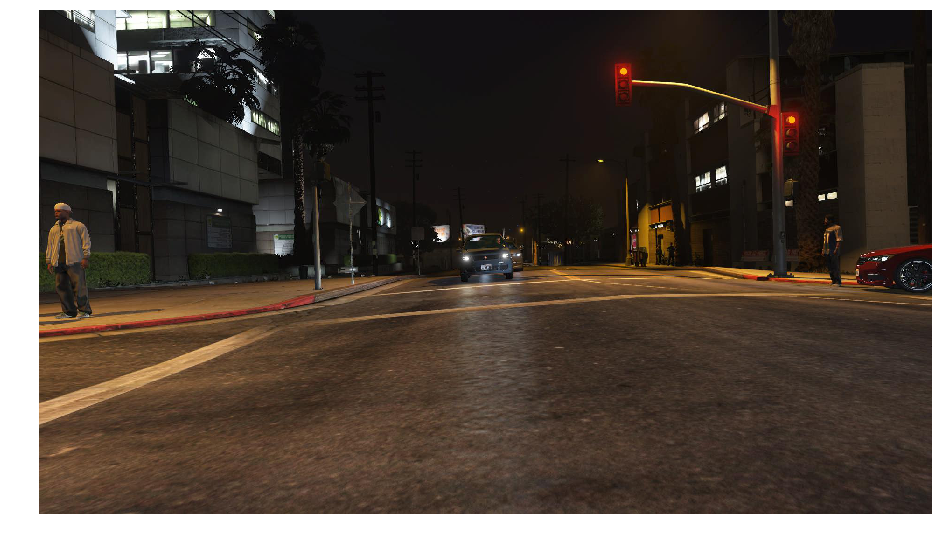

camera relative rot:
camera pos:  [339.657348632812, -1330.69873046875, 32.2111282348633]
2D bbox: [[ 1915.00052274   602.72937915]
 [ 1722.86528866   442.97561439]]
2D bbox: [[  10.32162122  573.17857458]
 [   0.          561.5812115 ]]


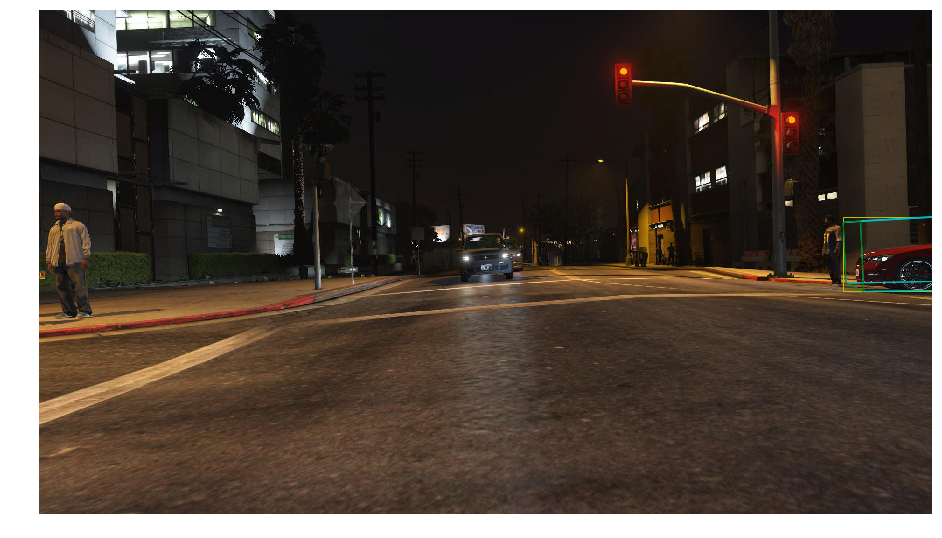

camera relative rot:
camera pos:  [328.402893066406, -1331.79357910156, 32.5836181640625]
2D bbox: [[  22.85531318  436.54472721]
 [   0.          410.847069  ]]
2D bbox: [[ 1915.00052274   507.42402314]
 [ 1908.24405957   496.55362607]]
2D bbox: [[ 1915.00052274  1053.00095147]
 [  353.22779707   171.63406498]]


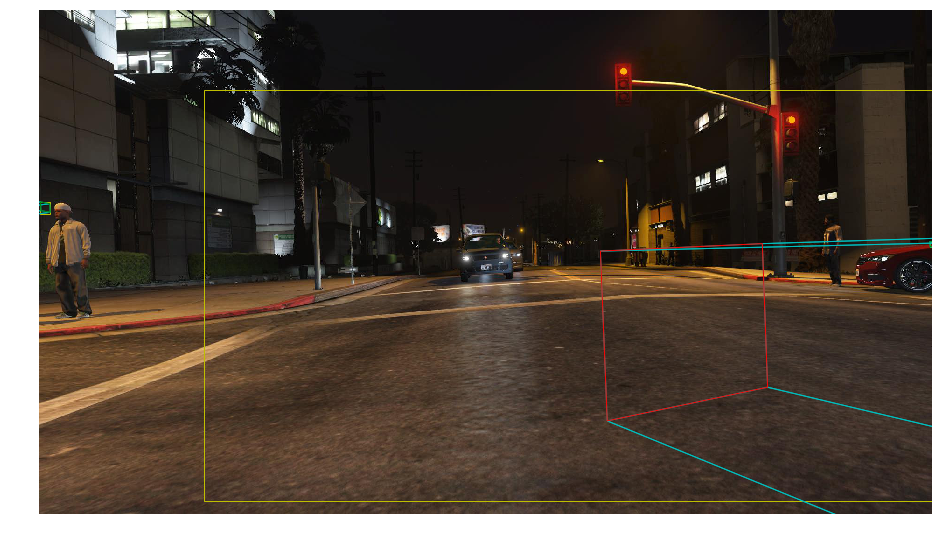

In [44]:
cur = conn.cursor()
cur.execute("""SELECT snapshot_id, scene_id, imagepath
    FROM snapshots
    WHERE scene_id = '{}'
    """.format('9460ac31-1d85-4240-b77d-d22148af28f6'))

results = []
for row in cur:
    res = dict(row)
    results.append(res)

print('there are {} results'.format(len(results)))
rgb_images = []
for res in results:
    rgb_file = os.path.join(directory, '{}.jpg'.format(res['imagepath']))
    depth_file = os.path.join(directory, '{}.png'.format(res['imagepath']))
    json_file = os.path.join(directory, '{}.json'.format(res['imagepath']))
    rgb = np.array(Image.open(rgb_file))
    rgb_images.append(rgb)
    depth = np.array(Image.open(depth_file))
    depth = depth / np.iinfo(np.uint16).max  # normalizing into NDC
    with open(json_file, mode='r') as f:
        data = json.load(f)
    if 'width' in data:
        width = data['width']
    else:
        width = 1914
        data['width'] = width
    if 'height' in data:
        height = data['height']
    else:
        height = 1052
        data['height'] = height
    
    print('camera relative rot:'.format(data['camera_relative_rotation']))
    fig = plt.figure(figsize=(16, 12))
    draw3dbboxes(rgb, depth, data, fig)
    plt.show()

In [18]:
list(data.keys())

['imagepath',
 'snapshot_id',
 'camera_rot',
 'camera_pos',
 'camera_relative_rotation',
 'view_matrix',
 'proj_matrix',
 'entities',
 'width',
 'height']

In [23]:
## seems like rgb data are messed up sometimes and are same for all cameras
for i in range(len(rgb_images)):
    for j in range(i, len(rgb_images)):
        print((rgb_images[i] == rgb_images[j]).all())
        
# nice, if cameras aren't switched, it is pixel-wise same

True
True
True
True
True
True
True
True
True
True


In [15]:
mpl.colors.to_hex('c')

'#00bfbf'

In [6]:
directory = r'D:\output-datasets\offroad-7'
base_name = r'0\2018-08-13--11-16-08--435'

rgb_file = os.path.join(directory, '{}.jpg'.format(base_name))
depth_file = os.path.join(directory, '{}-depth.png'.format(base_name))
stencil_file = os.path.join(directory, '{}-stencil.png'.format(base_name))
json_file = os.path.join(directory, '{}.json'.format(base_name))
rgb = np.array(Image.open(rgb_file))
depth = np.array(Image.open(depth_file))
stencil = np.array(Image.open(stencil_file))
with open(json_file, mode='r') as f:
    data = json.load(f)


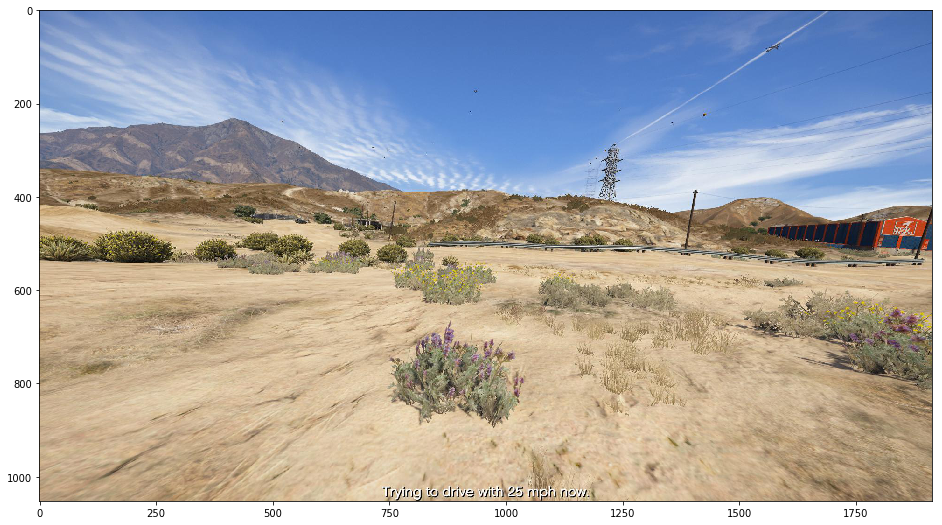

In [7]:
fig = plt.figure(figsize=(16, 12))
plt.imshow(rgb)
plt.show()


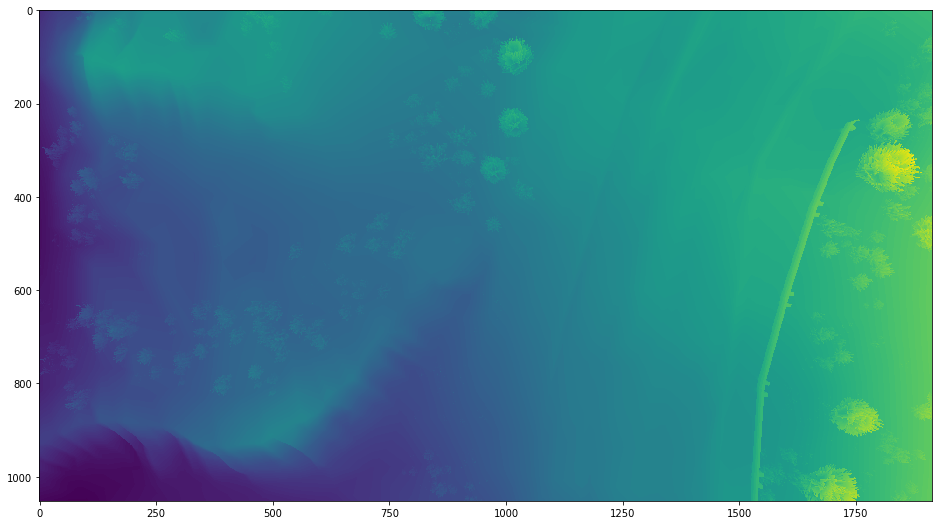

In [8]:
fig = plt.figure(figsize=(16, 12))
plt.imshow(depth)
plt.show()


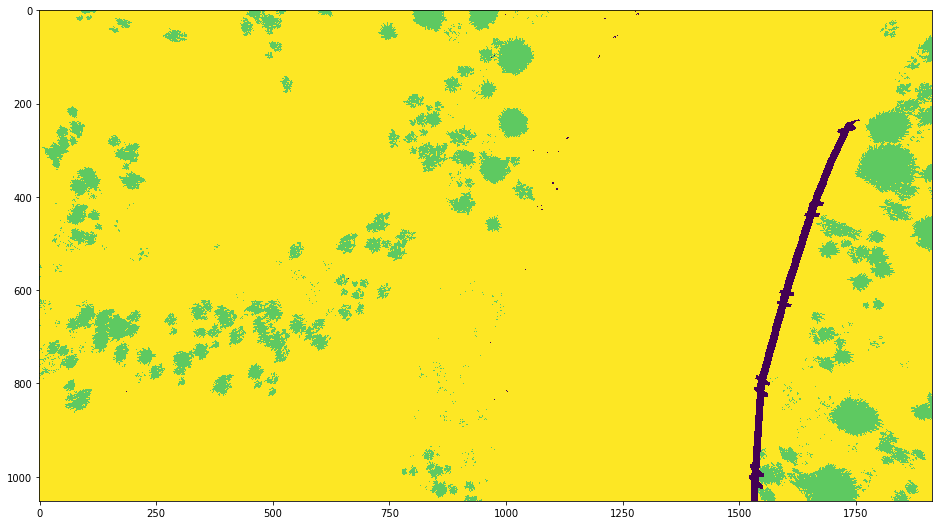

In [9]:
fig = plt.figure(figsize=(16, 12))
plt.imshow(stencil)
plt.show()


In [10]:
data

{'camera_fov': 90.0,
 'camera_pos': [2524.9169921875, 3336.18212890625, 53.2701759338379],
 'camera_relative_position': [-0.0599999986588955, 1.5, 1.07649993896484],
 'camera_relative_rotation': [0.0, 0.0, 0.0],
 'camera_rot': [-6.20057344436646, -4.97956657409668, -1.54253399372101],
 'current_target': [2586.0, 3490.0, None],
 'currentweather': 'Clear',
 'height': 1052,
 'imagepath': '2018-08-13--11-16-08--435',
 'proj_matrix': [[0.5496342737722049, 0.0, 0.0, 0.0],
  [0.0, 1.0000000000000002, 0.0, 0.0],
  [0.0, 0.0, 1.4994504514095583e-05, 0.1500022491756771],
  [0.0, 0.0, -1.0, 0.0]],
 'snapshot_id': 466715,
 'timeofday': '12:09:41',
 'timestamp': '2018-08-13 11:16:08',
 'view_matrix': [[0.9958647017289793,
   -0.026817444783909298,
   0.08680046374019536,
   -2429.6317032588067],
  [-0.08335389251723109,
   0.11029308118000451,
   0.9903976801497704,
   -210.2548054590532],
  [-0.036133425695287734,
   -0.9935372468604702,
   0.10760164798199054,
   3400.1231491838225],
  [0.0, 0.0,

In [11]:
camera_names = {
    'camera_-0.06_1.50_1.08__0.00_0.00_0.00': '0',
    'camera_15.94_17.50_6.08__-30.00_0.00_90.00': '1',
    'camera_-0.06_33.50_6.08__-30.00_0.00_180.00': '2',
    'camera_-16.06_17.50_6.08__-30.00_0.00_270.00': '3',
    'camera_0.48_1.50_1.08__0.00_0.00_0.00': '4',
    'camera_-0.06_17.50_25.08__270.00_0.00_90.00': '5',
}

are buffers same False 2018-08-13--11-16-07--018 2


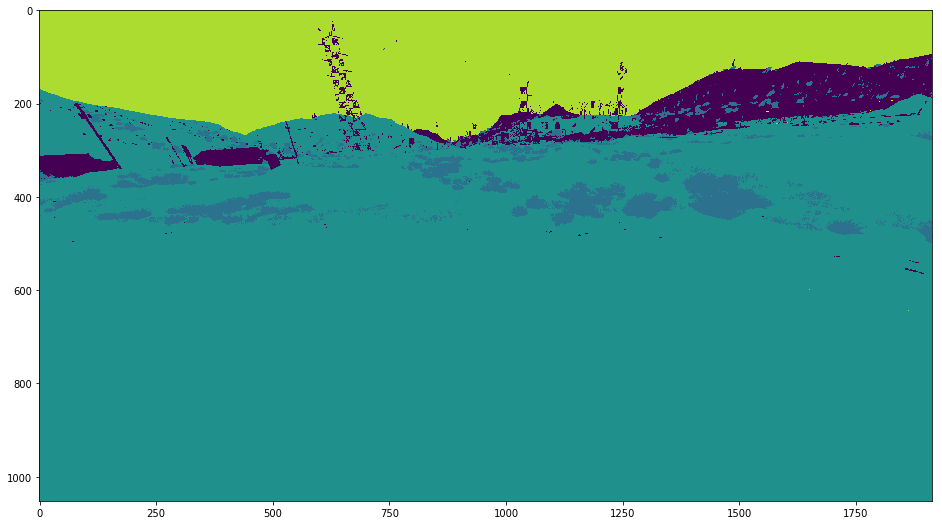

are buffers same False 2018-08-13--11-16-07--322 3


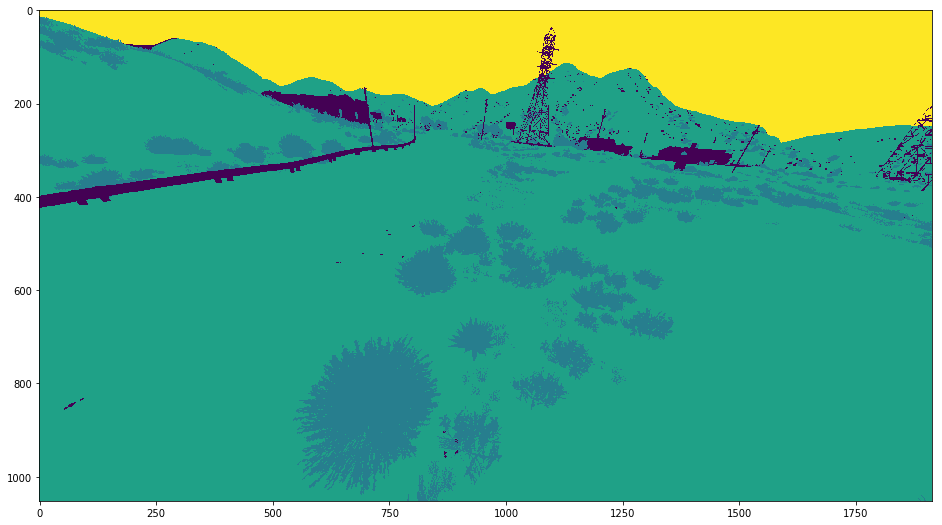

are buffers same False 2018-08-13--11-16-07--645 4


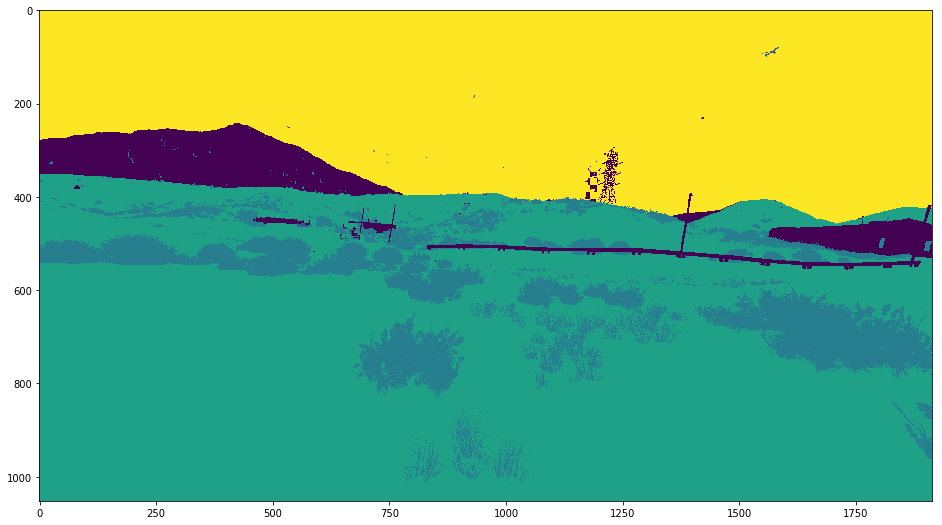

are buffers same False 2018-08-13--11-16-07--907 5


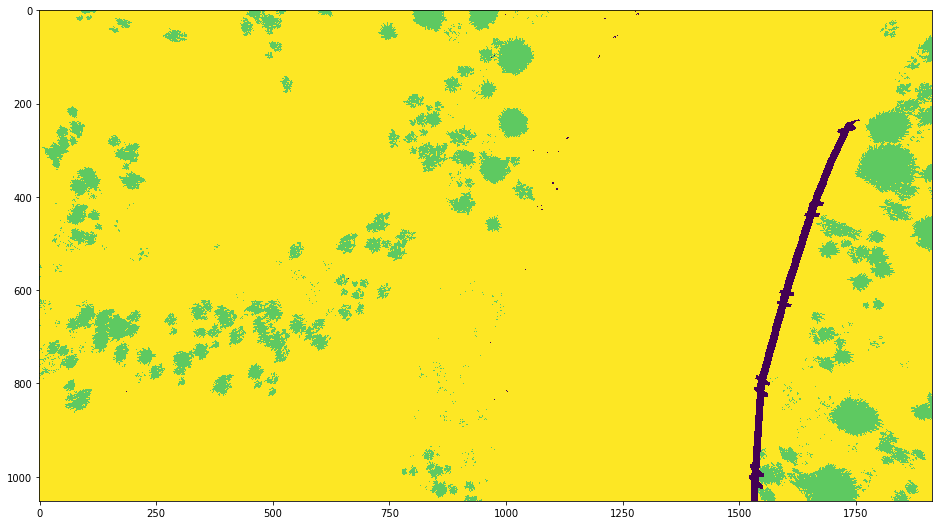

are buffers same True 2018-08-13--11-16-08--435 0


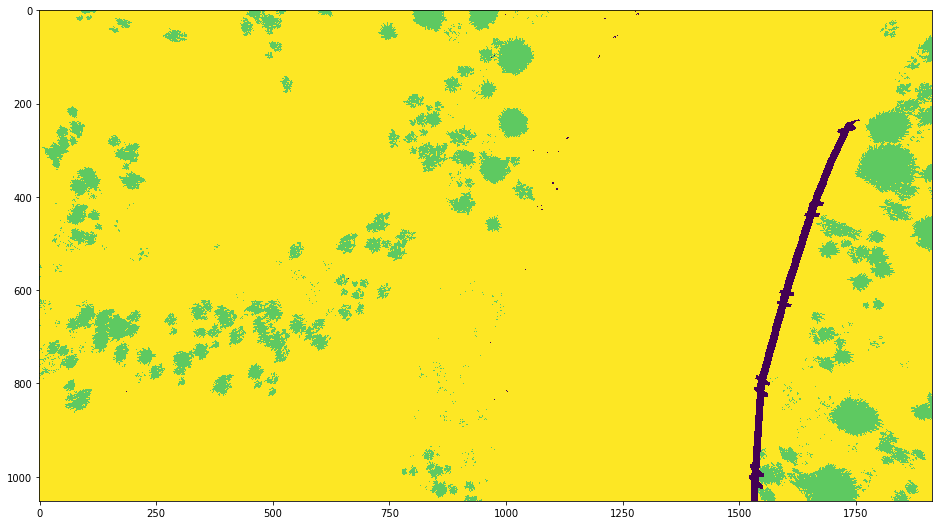

are buffers same True 2018-08-13--11-16-08--757 1


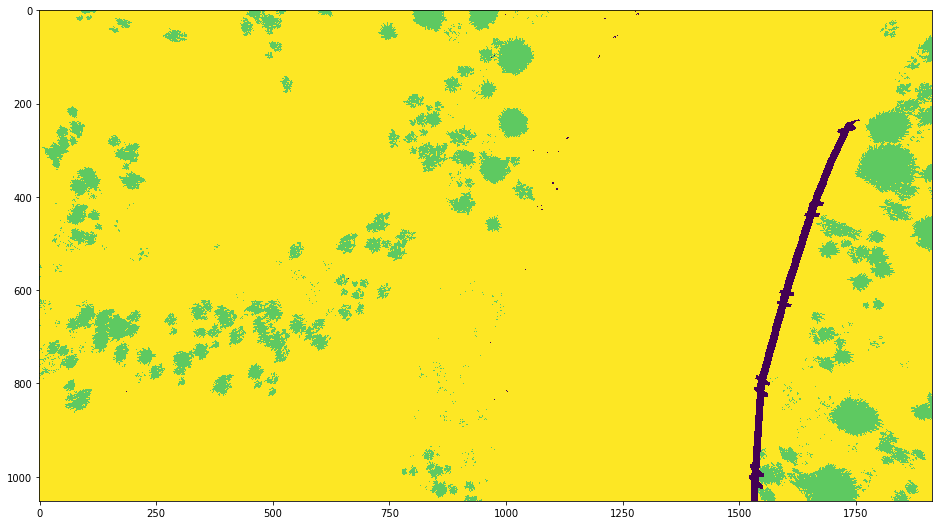

are buffers same True 2018-08-13--11-16-09--030 2


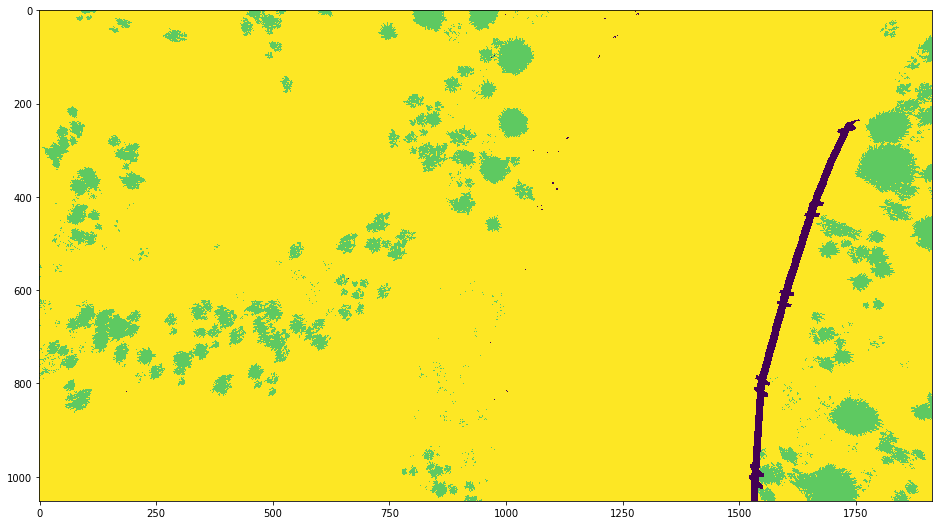

are buffers same True 2018-08-13--11-16-09--311 3


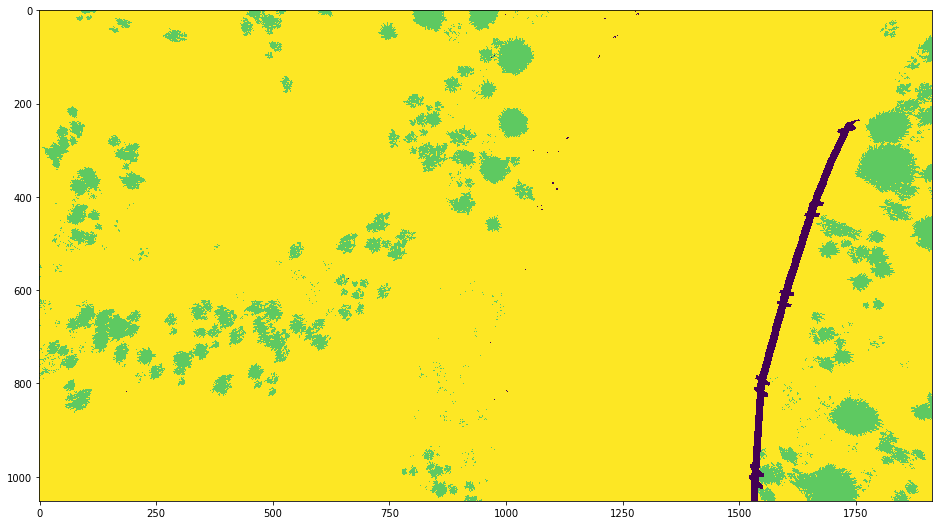

are buffers same True 2018-08-13--11-16-09--618 4


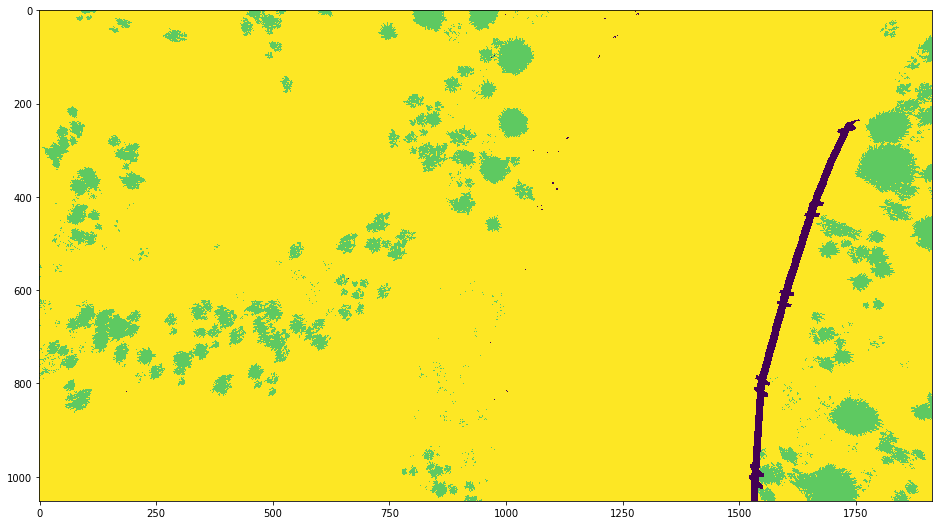

are buffers same True 2018-08-13--11-16-10--011 5


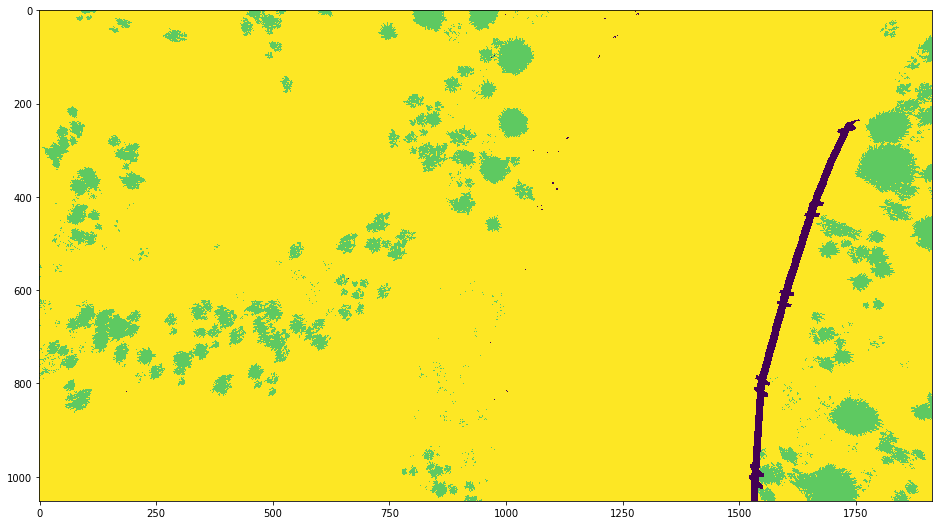

are buffers same True 2018-08-13--11-16-10--434 0


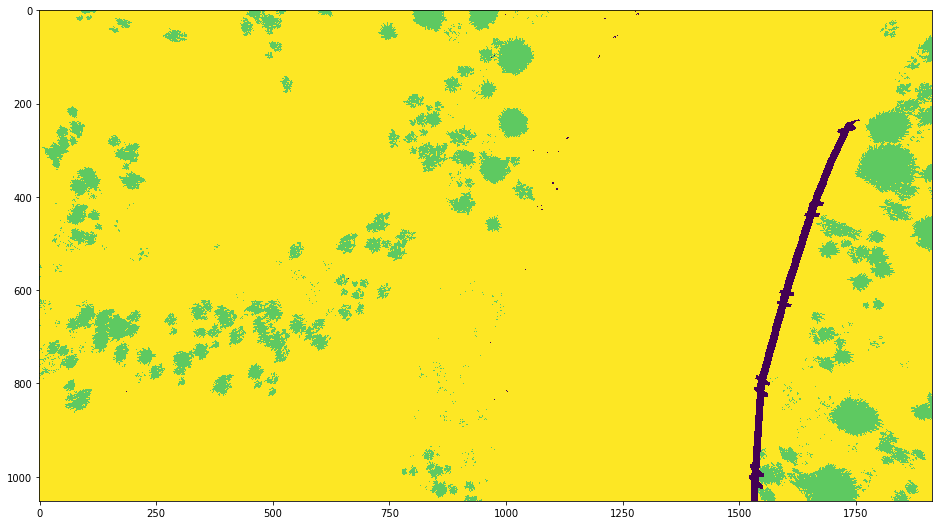

are buffers same False 2018-08-13--11-16-10--913 1


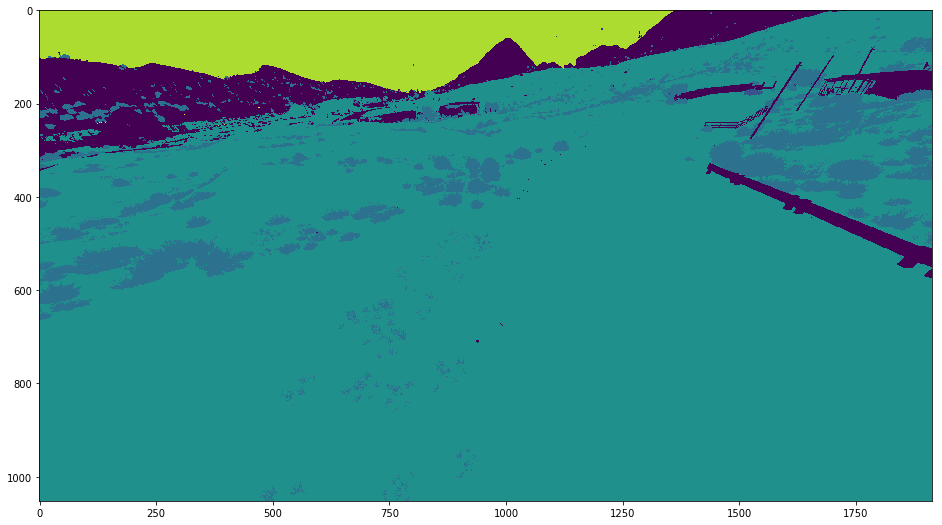

In [21]:
cur = conn.cursor()
cur.execute("""SELECT snapshot_id, scene_id, imagepath, timestamp, \
    ARRAY[st_x(camera_relative_rotation), st_y(camera_relative_rotation), st_z(camera_relative_rotation)] as camera_relative_rotation, \
    ARRAY[st_x(camera_relative_position), st_y(camera_relative_position), st_z(camera_relative_position)] as camera_relative_position \
    FROM snapshots \
    WHERE snapshot_id > {} - 5 AND snapshot_id < {} + 8 \
    """.format(data['snapshot_id'], data['snapshot_id']))

results = []
for row in cur:
    res = dict(row)
    results.append(res)

rgb_images = []
depth_images = []
stencil_images = []
for res in results:
    cam_name = 'camera_{}__{}'.format(
        '_'.join(['{:0.2f}'.format(i) for i in res['camera_relative_position']]), 
        '_'.join(['{:0.2f}'.format(i) for i in res['camera_relative_rotation']]), 
    )

    print('are buffers same', are_buffers_same_as_previous(res), res['imagepath'], camera_names[cam_name])
    rgb_file = os.path.join(visualization.in_directory, '{}.tiff'.format(res['imagepath']))
    json_file = os.path.join(directory, camera_names[cam_name], '{}.json'.format(res['imagepath']))
    rgb = Image.open(rgb_file)
    rgb = np.array(rgb.convert(mode="RGB"))
    depth = load_depth(res['imagepath'])
    depth = depth / np.iinfo(np.uint16).max  # normalizing into NDC
    stencil = load_stencil(res['imagepath'])
    rgb_images.append(rgb)
    depth_images.append(depth)
    stencil_images.append(stencil)
    
    fig = plt.figure(figsize=(16, 12))
    plt.imshow(stencil)
    plt.show()


In [21]:
print('rgb:')
for i in range(len(rgb_images)):
    for j in range(i, len(rgb_images)):
        print(i, j, (rgb_images[i] == rgb_images[j]).all())

print('depth:')
for i in range(len(depth_images)):
    for j in range(i, len(depth_images)):
        print(i, j, (depth_images[i] == depth_images[j]).all())
        
print('stencil:')
for i in range(len(stencil_images)):
    for j in range(i, len(stencil_images)):
        print(i, j, (stencil_images[i] == stencil_images[j]).all())
        

rgb:
0 0 True
0 1 False
0 2 False
0 3 False
0 4 False
1 1 True
1 2 False
1 3 False
1 4 False
2 2 True
2 3 False
2 4 False
3 3 True
3 4 False
4 4 True
depth:
0 0 True
0 1 False
0 2 False
0 3 False
0 4 False
1 1 True
1 2 True
1 3 True
1 4 True
2 2 True
2 3 True
2 4 True
3 3 True
3 4 True
4 4 True
stencil:
0 0 True
0 1 False
0 2 False
0 3 False
0 4 False
1 1 True
1 2 True
1 3 True
1 4 True
2 2 True
2 3 True
2 4 True
3 3 True
3 4 True
4 4 True
